#All Imports


In [206]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Functions Definition

In [207]:
def preprocess_text(text):
    text = re.sub(r'[^a-z ]', " ", text)
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\s+', " ", text.lower())
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [root_word] + [tupla[0] for tupla in model.wv.most_similar(root_word, topn=40)]
  X = model.wv[tot_words]
  if plot_3d:
    pca = TSNE(perplexity=40, n_components=3, init='pca')

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

#Globals

In [208]:
load_best_model = False

#Initializations

In [209]:
default_callbacks = []

#Data Download

In [210]:
data_df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
data_df.rename(columns= {'url':'text','is_spam':'label'},inplace= True)
data_df.label= data_df.label.replace(True,1)
data_df.label= data_df.label.replace(False,0)
data_df.head()

,text,label
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


#Data Cleaning

In [211]:
print(data_df.shape)
data_df = data_df.drop_duplicates()
data_df = data_df.reset_index(inplace = False, drop = True)
data_df.shape

(2999, 2)


(2369, 2)

<Axes: ylabel='label'>

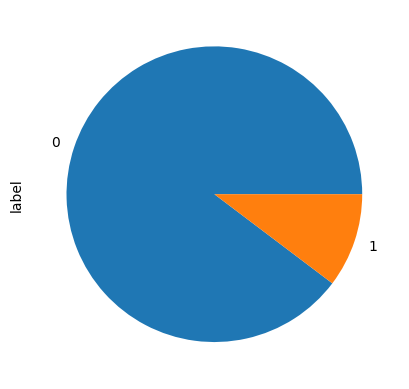

In [212]:
data_df.label.value_counts().plot.pie()

#Text Preprocessing

In [213]:
data_df["text"] = data_df["text"].apply(preprocess_text)
tokens_list = data_df["text"]
data_df["text"] = [" ".join(tokens) for tokens in tokens_list]
data_df.head()

,text,label
0,https briefingday us list manage com unsubscribe,1
1,https www hvper com,1
2,https briefingday com v i,1
3,https briefingday com m commentform,0
4,https briefingday com fan,1


#Machine Learning Model


In [214]:
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(data_df['text']).toarray()
y = data_df["label"]

In [215]:
X[0:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [217]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [218]:
predict_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, predict_train)
auc_roc_score_train = roc_auc_score(y_train, predict_train)
f1_score_train = f1_score(y_train, predict_train)
print('SVM Accuracy on the training set: ', accuracy_train)
print('SVM ROC AUC Score on the training set:', auc_roc_score_train)
print('SVM F1 score on the training set: ', f1_score_train)


SVM Accuracy on the training set:  0.9398416886543536
SVM ROC AUC Score on the training set: 0.7283807187184297
SVM F1 score on the training set:  0.6225165562913908


In [219]:
predict_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, predict_test)
auc_roc_score_test = roc_auc_score(y_test, predict_test)
f1_score_test = f1_score(y_test, predict_test)
print('SVM Accuracy on the test set: ', accuracy_test)
print('SVM ROC AUC Score on the test set:', auc_roc_score_test)
print('SVM F1 score on the test set: ', f1_score_test)


SVM Accuracy on the test set:  0.959915611814346
SVM ROC AUC Score on the test set: 0.7680813439434128
SVM F1 score on the test set:  0.6885245901639344


#Deep Learning

In [220]:
lst_corpus = list(tokens_list)
lst_corpus

[['https', 'briefingday', 'us', 'list', 'manage', 'com', 'unsubscribe'],
 ['https', 'www', 'hvper', 'com'],
 ['https', 'briefingday', 'com', 'v', 'i'],
 ['https', 'briefingday', 'com', 'm', 'commentform'],
 ['https', 'briefingday', 'com', 'fan'],
 ['https',
  'www',
  'brookings',
  'edu',
  'interactives',
  'reopening',
  'america',
  'and',
  'the',
  'world'],
 ['https',
  'www',
  'reuters',
  'com',
  'investigates',
  'special',
  'report',
  'health',
  'coronavirus',
  'britain',
  'pub'],
 ['https',
  'www',
  'theatlantic',
  'com',
  'magazine',
  'archive',
  'supermarkets',
  'are',
  'miracle'],
 ['https',
  'www',
  'vox',
  'com',
  'john',
  'bolton',
  'book',
  'excerpts',
  'trump',
  'ukraine',
  'china'],
 ['https',
  'www',
  'theguardian',
  'com',
  'travel',
  'jun',
  'end',
  'of',
  'tourism',
  'coronavirus',
  'pandemic',
  'travel',
  'industry'],
 ['https',
  'www',
  'bbc',
  'com',
  'future',
  'article',
  'what',
  'if',
  'all',
  'viruses',
  'd

In [221]:
embedding_model = Word2Vec(lst_corpus, vector_size=300, window=8, sg=1, epochs=30)
embedding_model.save("url_spam.embedding_model")

In [222]:
vocab_len = len(embedding_model.wv)
vocab_len

737

In [223]:
list(embedding_model.wv.index_to_key)

['https',
 'com',
 'www',
 'the',
 'html',
 'news',
 'us',
 'to',
 'of',
 'coronavirus',
 'org',
 'article',
 'in',
 'and',
 'morningbrew',
 'story',
 'on',
 'nytimes',
 'daily',
 'stories',
 'for',
 'utm',
 'youtube',
 'numlock',
 'trump',
 'watch',
 'id',
 'is',
 'new',
 'substack',
 'world',
 'reuters',
 'a',
 'index',
 'briefingday',
 'covid',
 'en',
 'vox',
 'cnn',
 'articles',
 'e',
 'c',
 'co',
 'cnbc',
 'politics',
 'sunday',
 'business',
 'court',
 'apnews',
 'b',
 'facebook',
 'health',
 'bbc',
 'supreme',
 'be',
 'from',
 'blog',
 'medium',
 'black',
 'are',
 'd',
 'npr',
 's',
 'police',
 'with',
 'digg',
 'cases',
 'apple',
 'theverge',
 'theguardian',
 'source',
 'why',
 'as',
 'live',
 'how',
 'http',
 'what',
 'email',
 'jun',
 'this',
 'video',
 'tech',
 'will',
 'edu',
 'amazon',
 'pandemic',
 'f',
 'list',
 'google',
 'about',
 'mc',
 'people',
 'wsj',
 'feature',
 'nbcnews',
 'politico',
 'axios',
 'usa',
 'travel',
 'updates',
 'at',
 'says',
 'law',
 'uk',
 'fb',


In [224]:
embedding_model.wv.vectors.shape

(737, 300)

#Word Embeddings Sanity Check

In [225]:
word = "http"
embedding_model.wv[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model.wv[word])

Embeddings Coefficients for the word:  http


[-1.67480111e-01  4.81855124e-02  1.42998993e-02  6.69089183e-02
 -1.88048452e-01 -5.26314713e-02  2.22220289e-04  2.81821221e-01
 -2.23894387e-01  7.97025580e-03  7.42931813e-02 -1.83100030e-02
  2.97596790e-02  5.46008833e-02  2.82146223e-02 -1.91878229e-02
  8.57232660e-02  2.81276857e-03 -1.10502325e-01 -1.10402517e-02
 -6.57753721e-02  2.61947811e-02  1.58301592e-02  5.66056408e-02
  2.01834112e-01  1.79110929e-01 -1.87057719e-01 -5.59220873e-02
 -8.43984038e-02 -1.84984982e-01 -5.61378300e-02  1.95772186e-01
  6.62780181e-03  7.17395172e-02  1.59009859e-01  1.31177559e-01
  1.18066728e-01 -1.82249159e-01  2.43338406e-01 -4.66453619e-02
 -1.65112406e-01  7.36874044e-02 -1.73485652e-01 -6.22753315e-02
 -7.59109035e-02 -5.63940182e-02 -3.48082148e-02 -7.67873451e-02
 -6.92649232e-03 -2.74824556e-02 -5.08614555e-02  1.93442211e-01
  5.72048798e-02  2.41827071e-02  7.61700943e-02  2.60300517e-01
  1.07904613e-01  1.99760228e-01 -1.15533225

<ipython-input-207-136fead24086>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_data["input"].iloc[0:1] = 1


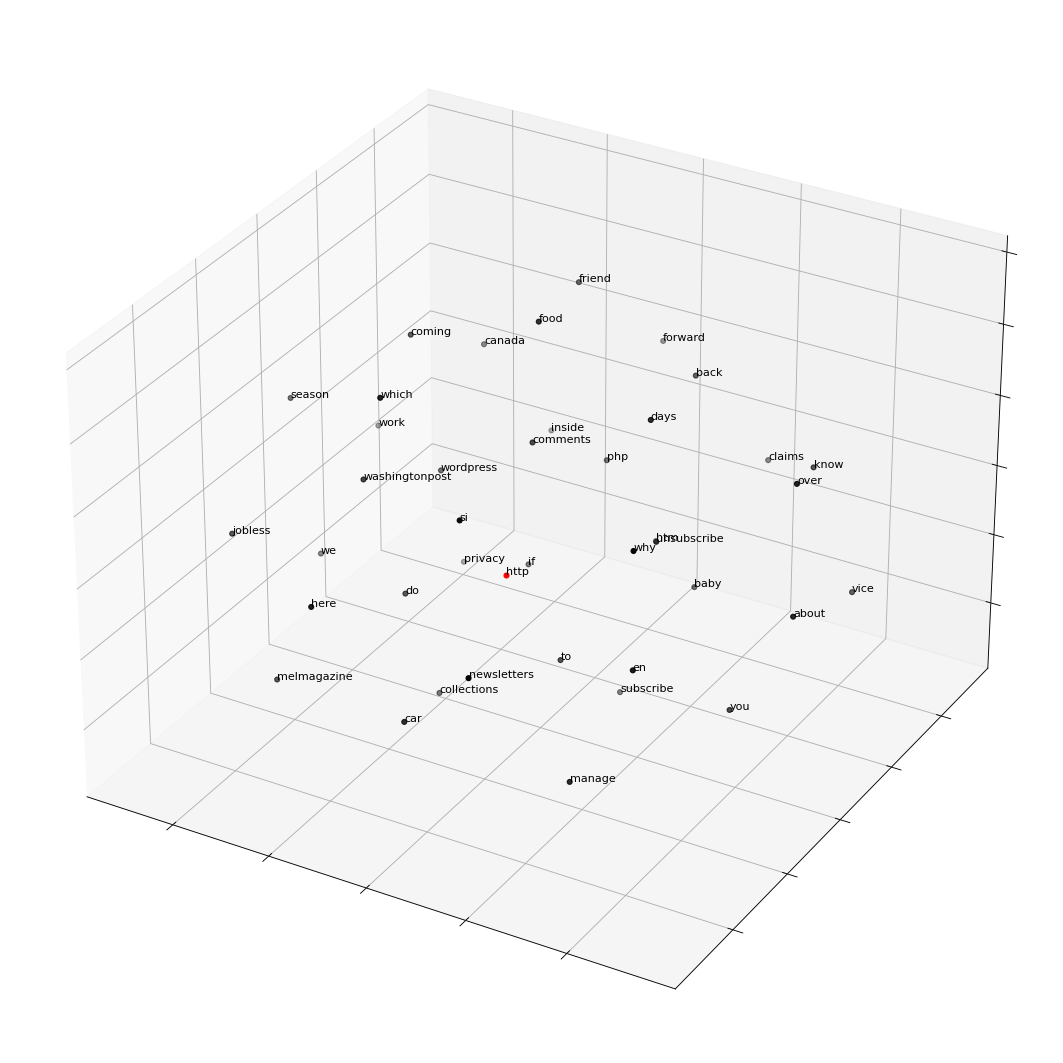

In [226]:
embedding_space_visualization("http", embedding_model)

#Tokenization

In [227]:
tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
index_of_words = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
sequences = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

#Train-Test Split

In [228]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size = 0.2, random_state = 42)

#Self-Trained Embedding Matrix

In [229]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model.wv[word]
    except:
        pass
print(embeddings_matrix.shape)

(5970, 300)


#Labels Encoding

In [230]:
print("Original Labels: ")
print(y_train)
print(y_test)
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
print("One-Hot Encoded Labels: ")
print(y_train)
print(y_test)
print(len(y_train))
print(len(y_test))

Original Labels: 
163     0
1102    0
765     0
423     0
1608    0
       ..
1638    0
1095    0
1130    0
1294    0
860     0
Name: label, Length: 1895, dtype: int64
1094    0
188     0
1800    1
707     0
679     0
       ..
620     0
286     0
1050    0
406     0
1270    0
Name: label, Length: 474, dtype: int64
One-Hot Encoded Labels: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0.

#Deep Neural Network Definition

In [231]:
input = Input(shape=(15,))
x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], input_length=15, weights=[embeddings_matrix], trainable=False)(input)
x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 15, 300)           1791000   
                                                                 
 bidirectional_14 (Bidirect  (None, 15, 30)            37920     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 30)                5520      
 ional)                                                          
                                                                 
 dense_13 (Dense)            (None, 64)                1984      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

#Callbacks Definitions

In [232]:
checkPoint=ModelCheckpoint(f"./url_spam_best.hd5", save_weights_only=False, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
default_callbacks = default_callbacks+[checkPoint]

earlyStopping=EarlyStopping(monitor='val_loss', min_delta = 0.01, patience=10, verbose=0, mode='min')
default_callbacks = default_callbacks+[earlyStopping]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_delta = 0.01, min_lr=0.001)
default_callbacks = default_callbacks+[reduce_lr]

#Deep Model Training

In [233]:
history = model.fit(X_train, y_train, batch_size=64, epochs=30, shuffle=True, callbacks = default_callbacks, verbose=1, validation_split=0.2)

Epoch 1/30
23/24 [===========================>..] - ETA: 0s - loss: 0.4597 - accuracy: 0.8662
Epoch 1: val_accuracy improved from -inf to 0.89182, saving model to ./url_spam_best.hd5
24/24 [==============================] - 32s 950ms/step - loss: 0.4538 - accuracy: 0.8681 - val_loss: 0.3366 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8958
Epoch 2: val_accuracy improved from 0.89182 to 0.91557, saving model to ./url_spam_best.hd5
24/24 [==============================] - 23s 1s/step - loss: 0.2967 - accuracy: 0.8958 - val_loss: 0.2542 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9116
Epoch 3: val_accuracy did not improve from 0.91557
24/24 [==============================] - 1s 30ms/step - loss: 0.2440 - accuracy: 0.9116 - val_loss: 0.2411 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 4/30
20/24 [========================>.....] - ETA:

In [234]:
model.save("url_spam_last.hd5")

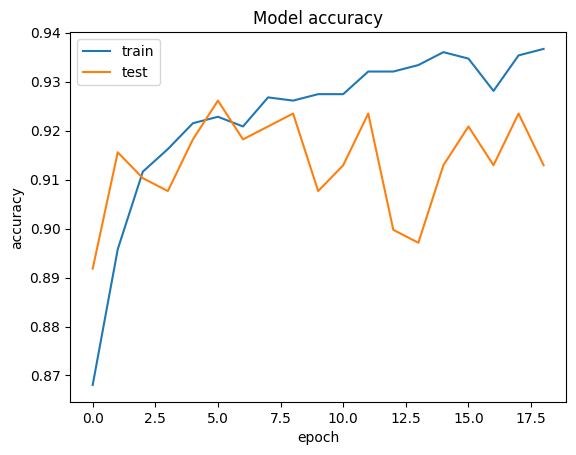

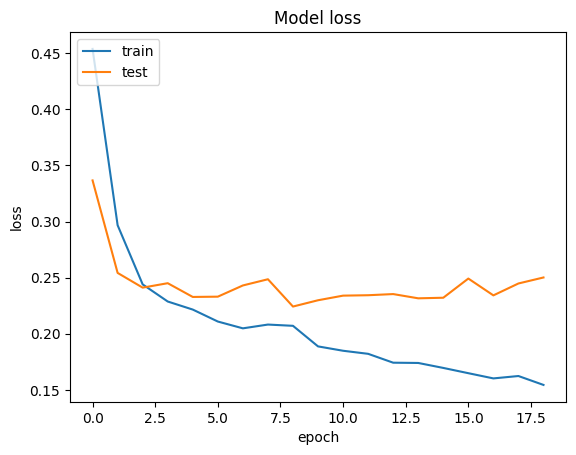

In [235]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [236]:
if load_best_model is True:
  model = load_model("./url_spam_best.hd5")
else:
  model = load_model("./url_spam_last.hd5")

In [237]:
predict_train = np.argmax(model.predict(X_train), axis = 1)
y_train = np.argmax(y_train, axis = 1)
accuracy_train = accuracy_score(y_train, predict_train)
auc_roc_score_train = roc_auc_score(y_train, predict_train)
f1_score_train = f1_score(y_train, predict_train)
print('SVM Accuracy on the training set: ', accuracy_train)
print('SVM ROC AUC Score on the training set:', auc_roc_score_train)
print('SVM F1 score on the training set: ', f1_score_train)

60/60 [==============================] - 3s 6ms/step
SVM Accuracy on the training set:  0.9329815303430079
SVM ROC AUC Score on the training set: 0.7566820609034492
SVM F1 score on the training set:  0.6318840579710145


In [238]:
predict_test = np.argmax(model.predict(X_test), axis = 1)
y_test = np.argmax(y_test, axis = 1)
accuracy_test = accuracy_score(y_test, predict_test)
auc_roc_score_test = roc_auc_score(y_test, predict_test)
f1_score_test = f1_score(y_test, predict_test)
print('SVM Accuracy on the test set: ', accuracy_test)
print('SVM ROC AUC Score on the test set:', auc_roc_score_test)
print('SVM F1 score on the test set: ', f1_score_test)

15/15 [==============================] - 0s 8ms/step
SVM Accuracy on the test set:  0.9535864978902954
SVM ROC AUC Score on the test set: 0.7996463306808135
SVM F1 score on the test set:  0.6857142857142857
